# Library

In [1]:
import numpy as np, os
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

# Data load

In [10]:
# LSH
all_df = pd.read_csv('df_all_best.csv')
all_df = all_df.sort_values(by='diff',ascending=False)

df_d1d5 = pd.read_csv('df_d1d5_best.csv')
df_d1d5 = df_d1d5.sort_values(by='diff',ascending=False)

df_d6d10 = pd.read_csv('df_d6d10_best.csv')
df_d6d10 = df_d6d10.sort_values(by='diff',ascending=False)

# Method 2 : 변동성
$$
FI^{역전} = FI^{원시간} - FI^{근시간}
$$ 

$$
FI^{근시간} = Relu(FI^{d1d5,inverse}) * sign(FI^{d1d5, 0->1})
$$
$$
FI^{원시간} = Relu(FI^{d6d10,inverse}) * sign(FI^{d6d10, 0->1})
$$

$$
FI^{our} = Relu(FI^{inverse}) * sign(FI^{0->1})
$$

## 근시간에 대한 FI^our
$$
FI^{근시간} = Relu(FI^{d1d5,inverse}) * sign(FI^{d1d5, 0->1})
$$
$$
FI^{원시간} = Relu(FI^{d6d10,inverse}) * sign(FI^{d6d10, 0->1})
$$

### 일관성

In [20]:
# 1. 일관성
m2_일관성_df1 = df_d1d5[['feature','diff']]
m2_일관성_df1.loc[(m2_일관성_df1['diff'] <= 0),'diff'] = 0
m2_일관성_df1 = m2_일관성_df1.sort_values(by='feature')
m2_일관성_df1.index = list(range(4068))
m2_일관성_df1

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,feature,diff
0,0,0.000000
1,50803,0.000739
2,50804,0.003245
3,50805,0.000276
4,50806,0.004817
...,...,...
4063,78112001103,0.000263
4064,79511050204,0.000000
4065,87701071218,0.009628
4066,87701083336,0.000000


### 방향성

In [9]:
# 1) DATA 
import random    
# ---------------------
seed_num = 42
# ---------------------
random.seed(seed_num)

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

# 3)
# FEATURES
a = pd.read_csv('total_data_7727.csv')
features = list(a['ITEMID'].sort_values().unique()) # 4068개 ITEMID 

# No Change에 대한 평균예측값 (baseline)
preds = lstm2.predict(X_test)
pred_base = np.mean(preds)

# COMPUTE BASELINE
results = []
results.append({'feature':'BASELINE','pred_base':pred_base}) 

for k in tqdm(range(len(features))):

    # REVERSE ALL FEATURE K
    save_col = X_test[:,:,k].copy()
    X_test[:,5:,k] = np.where(X_test[:,5:,k]==0, 1, X_test[:,5:,k])

    # COMPUTE BCE WITH FEATURE K REVERSED
    pred2 = lstm2.predict(X_test)
    pred2_mean = np.mean(pred2)
    
    results.append({'feature':features[k],'pred2':pred2_mean})
    X_test[:,:,k] = save_col

100%|██████████| 4068/4068 [41:25<00:00,  1.64it/s] 


In [11]:
# 4) diff 구해서 sign함수에 적용

방향성_df = pd.DataFrame(results)
pred_base = 방향성_df.iloc[0,1]
방향성_df = 방향성_df.drop(index=0, columns=['pred_base'])
방향성_df['diff'] = 방향성_df['pred2']-pred_base

방향성_df.loc[(방향성_df['diff']>0),'diff'] = 1
방향성_df.loc[(방향성_df['diff']<=0),'diff'] = -1
방향성_df = 방향성_df.sort_values(ascending=True, by='feature')
# 방향성_df.to_csv('m2_방향성df_근시간.csv',index=False)

In [21]:
# 2. 방향성
m2_방향성_df1 = pd.read_csv('m2_방향성df_근시간.csv')
m2_방향성_df1.index = list(range(4068))

### 일관성 * 방향성

In [22]:
# 3. 일관성 * 방향성
FI_our_근시간 = m2_일관성_df1.copy()
FI_our_근시간['mul'] = m2_일관성_df1['diff'] * m2_방향성_df1['diff']
FI_our_근시간

,feature,diff,mul
0,0,0.000000,-0.000000
1,50803,0.000739,-0.000739
2,50804,0.003245,0.003245
3,50805,0.000276,-0.000276
4,50806,0.004817,0.004817
...,...,...,...
4063,78112001103,0.000263,-0.000263
4064,79511050204,0.000000,-0.000000
4065,87701071218,0.009628,0.009628
4066,87701083336,0.000000,0.000000


## 원시간에 대한 FI^our

### 일관성

In [23]:
# 1. 일관성
m2_일관성_df2 = df_d6d10[['feature','diff']]
m2_일관성_df2.loc[(m2_일관성_df2['diff'] <= 0),'diff'] = 0
m2_일관성_df2 = m2_일관성_df2.sort_values(by='feature')
m2_일관성_df2.index = list(range(4068))
m2_일관성_df2

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,feature,diff
0,0,0.000000
1,50803,0.000890
2,50804,0.000546
3,50805,0.000613
4,50806,0.000000
...,...,...
4063,78112001103,0.000454
4064,79511050204,0.000011
4065,87701071218,0.000000
4066,87701083336,0.000000


### 방향성

In [4]:
# 1) DATA 
import random    
# ---------------------
seed_num = 42
# ---------------------
random.seed(seed_num)

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

# 3)
# FEATURES
a = pd.read_csv('total_data_7727.csv')
features = list(a['ITEMID'].sort_values().unique()) # 4068개 ITEMID 

# No Change에 대한 평균예측값 (baseline)
preds = lstm2.predict(X_test)
pred_base = np.mean(preds)

# COMPUTE BASELINE
results = []
results.append({'feature':'BASELINE','pred_base':pred_base}) 

for k in tqdm(range(len(features))):

    # REVERSE ALL FEATURE K
    save_col = X_test[:,:,k].copy()
    X_test[:,:5,k] = np.where(X_test[:,:5,k]==0, 1, X_test[:,:5,k])

    # COMPUTE BCE WITH FEATURE K REVERSED
    pred2 = lstm2.predict(X_test)
    pred2_mean = np.mean(pred2)
    
    results.append({'feature':features[k],'pred2':pred2_mean})
    X_test[:,:,k] = save_col

Using TensorFlow backend.
100%|██████████| 4068/4068 [33:05<00:00,  2.05it/s]


In [8]:
# 4) diff 구해서 sign함수에 적용

방향성_df = pd.DataFrame(results)
pred_base = 방향성_df.iloc[0,1]
방향성_df = 방향성_df.drop(index=0, columns=['pred_base'])
방향성_df['diff'] = 방향성_df['pred2']-pred_base

방향성_df.loc[(방향성_df['diff']>0),'diff'] = 1
방향성_df.loc[(방향성_df['diff']<=0),'diff'] = -1
방향성_df = 방향성_df.sort_values(ascending=True, by='feature')
# 방향성_df.to_csv('m2_방향성df_원시간.csv',index=False)

In [12]:
# 2. 방향성
m2_방향성_df2 = pd.read_csv('m2_방향성df_원시간.csv')
m2_방향성_df2.index = list(range(4068))

### 일관성 * 방향성

In [13]:
# 3. 일관성 * 방향성
FI_our_원시간 = m2_일관성_df2.copy()
FI_our_원시간['mul'] = m2_일관성_df2['diff'] * m2_방향성_df2['diff']
FI_our_원시간

NameError: name 'm2_일관성_df2' is not defined

## 원시간 - 근시간

In [31]:
method2 = FI_our_근시간.copy()[['feature','mul']]
method2['diff2'] = FI_our_원시간['mul'] - FI_our_근시간['mul']

method2 = method2.sort_values(ascending=False, by='diff2')
method2

# method2.to_csv('method2_df.csv',index=False)

,feature,mul,diff2
383,227194,-0.011878,0.009464
469,4003822,-0.009620,0.007752
3818,63323016101,-0.008225,0.006699
37,50889,-0.008520,0.006538
2860,25021011210,-0.008035,0.006379
...,...,...,...
2744,10019055302,0.021081,-0.021081
982,54817525,0.022155,-0.022155
1081,67434504,0.024894,-0.024894
1276,74606211,0.028581,-0.028581


# 그래프

In [5]:
total_data = pd.read_csv('total_data_7727.csv')
x = np.load('/project/LSH/x_(7727,10,4068).npy')

def absum(PPL_list,top_or_down):
    # 1) PRE_top10의 index 구하기
    PPL_top10 = top_or_down
    item_list = total_data['ITEMID'].sort_values().unique()

    PPL_index = []
    for i in PPL_top10:
        a = list(item_list).index(i)
        PPL_index.append(a)
    
    # 2) 생존자 index 구하기 
    sub7727 = total_data['SUBJECT_ID'].unique()

    patient = pd.read_csv('폐렴환자.csv')
    patient = patient.sort_values(by='SUBJECT_ID')
    patient = patient[patient['SUBJECT_ID'].isin(sub7727)]
    sub_1_list = patient[patient['EXPIRE_FLAG']==0]['SUBJECT_ID'].values

    생존자_index = []
    for i in sub_1_list:
        생존자_index.append(list(sub7727).index(i))
        
    # 3) 생존자 3009명의 D-10 ~ D-1 feature별 abnormal sum 
    x_생존자 = x[생존자_index,:,:]

    result1 = []
    for i in PPL_index:
        for j in range(10):
            result1.append(x_생존자[:,j,i].sum())

    result1 = np.array(result1)
    result1 = result1.reshape(10,-1)
    df_PPL = pd.DataFrame(result1)
    df_PPL.columns = [f'D-{i}' for i in range(10,0,-1)]
    df_PPL.index = PPL_top10

    # 생존한 4718명에 대한 비율 계산
    for i in PPL_top10:
        df_PPL.loc[f'{i}_생존'] = df_PPL.loc[i].iloc[:]/x_생존자.shape[0]
        
    # 4) 사망자 4718명의 D-10 ~ D-1 feature별 abnormal sum 
    사망자_index = list(set(range(0,7727))-set(생존자_index))

    x_사망자 = x[사망자_index,:,:]

    result2 = []
    for i in PPL_index:
        for j in range(10):
            result2.append(x_사망자[:,j,i].sum())

    result2 = np.array(result2)
    result2 = result2.reshape(10,-1)
    df_PPL_사망자 = pd.DataFrame(result2)
    df_PPL_사망자.columns = [f'D-{i}' for i in range(10,0,-1)]
    df_PPL_사망자.index = PPL_top10

    # 사망한 3009명에 대한 비율 계산
    for i in PPL_top10:
        df_PPL_사망자.loc[f'{i}_사망'] = df_PPL_사망자.loc[i]/x_사망자.shape[0] 
        
    # 5) for문으로 각 feature에 대한 비율 추이 그래프 그리기 

    df_PPL_trans = df_PPL.transpose()
    df_PPL_사망자_trans = df_PPL_사망자.transpose()

    _ = plt.figure(figsize = (13,12),dpi=150)
    for i, f in enumerate(PPL_top10): 
        _ = plt.subplot(4,3,1+i)
        _ = plt.title(f)
        _ = ax = sns.lineplot(data = df_PPL_사망자_trans, x = df_PPL_사망자_trans.index, y = f'{f}_사망')
        _ = ax = sns.lineplot(data = df_PPL_trans, x = df_PPL_trans.index, y = f'{f}_생존')
        _ = ax.legend(labels = ['사망', '생존'], loc = 'upper left', fontsize=12)
        _ = ax.set_ylabel('per', fontsize = 12)

    plt.tight_layout()

In [6]:
method2 = pd.read_csv('method2_df.csv')
m2_feature = method2['feature'].tolist()

# LAB, PRE, PRO의 item_list 생성 
LAB_item = total_data[total_data['TYPE']=='LAB']['ITEMID'].unique()
PRE_item = total_data[total_data['TYPE']=='PRE']['ITEMID'].unique()
PRO_item = total_data[total_data['TYPE']=='PRO']['ITEMID'].unique()

LAB_list = []
PRE_list = []
PRO_list = []
for i in m2_feature:
    if i in LAB_item:
        LAB_list.append(i)
    elif i in PRE_item:
        PRE_list.append(i)
    else:
        PRO_list.append(i)

## PRE

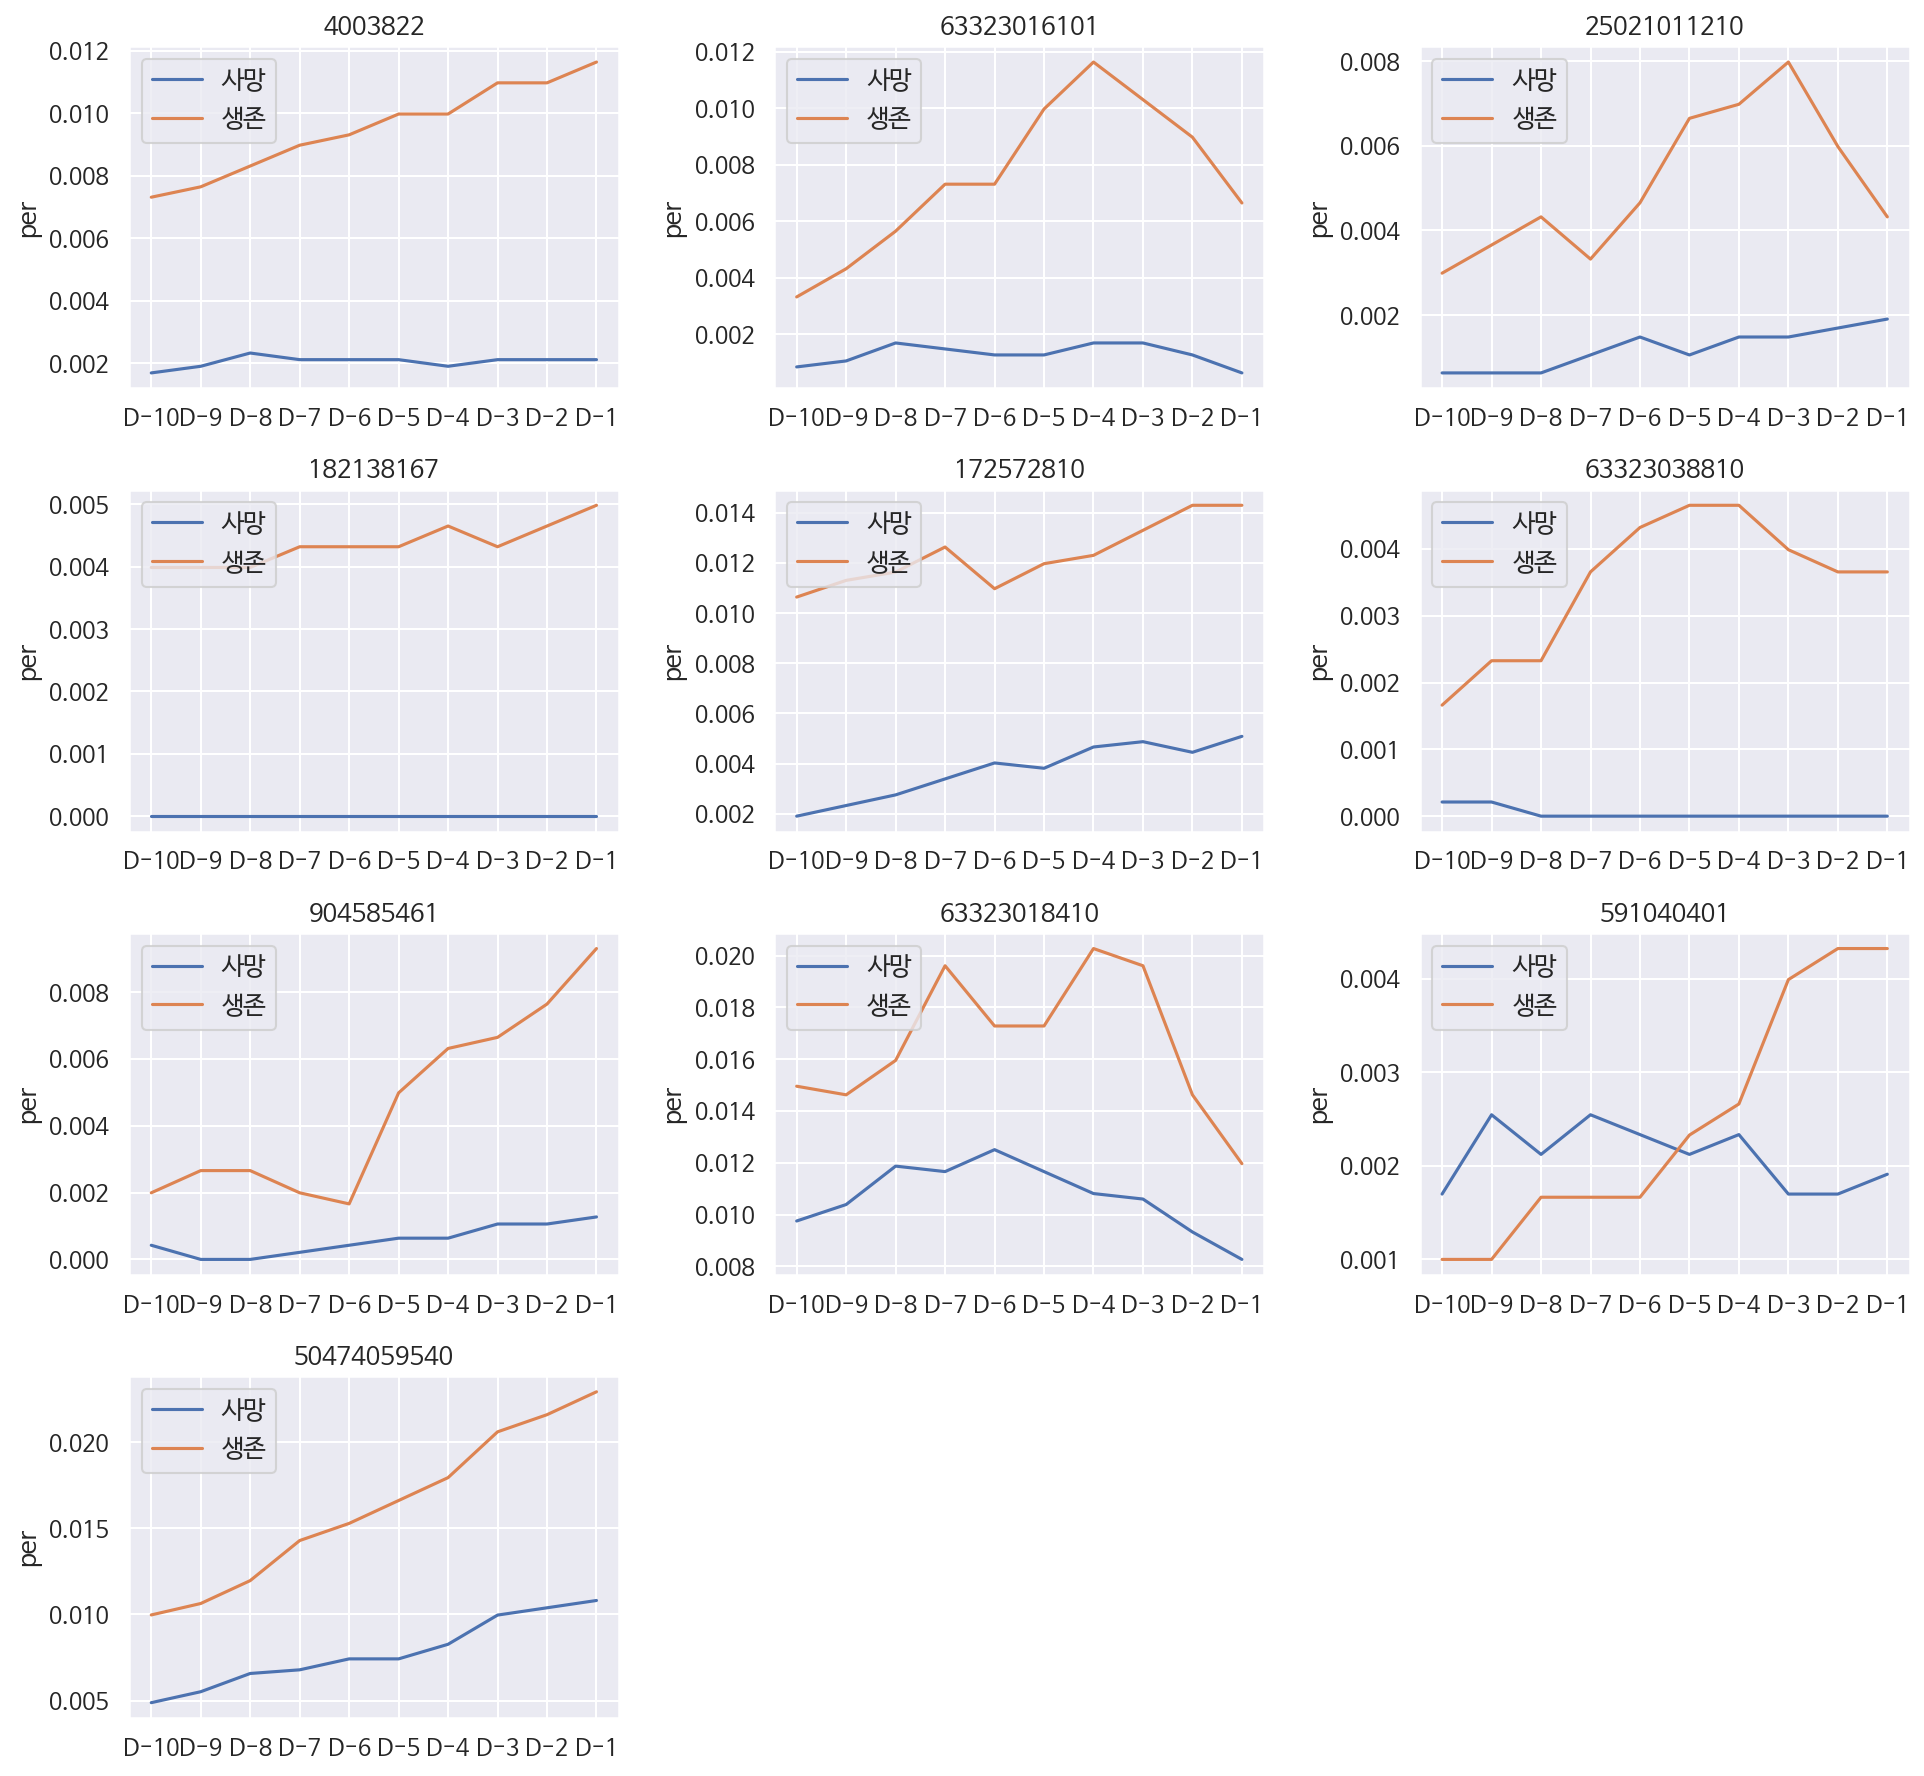

In [35]:
# 상위 10개 - '사망 -> 생존'으로의 변동성이 큰 feature
absum(PRE_list,PRE_list[:10])

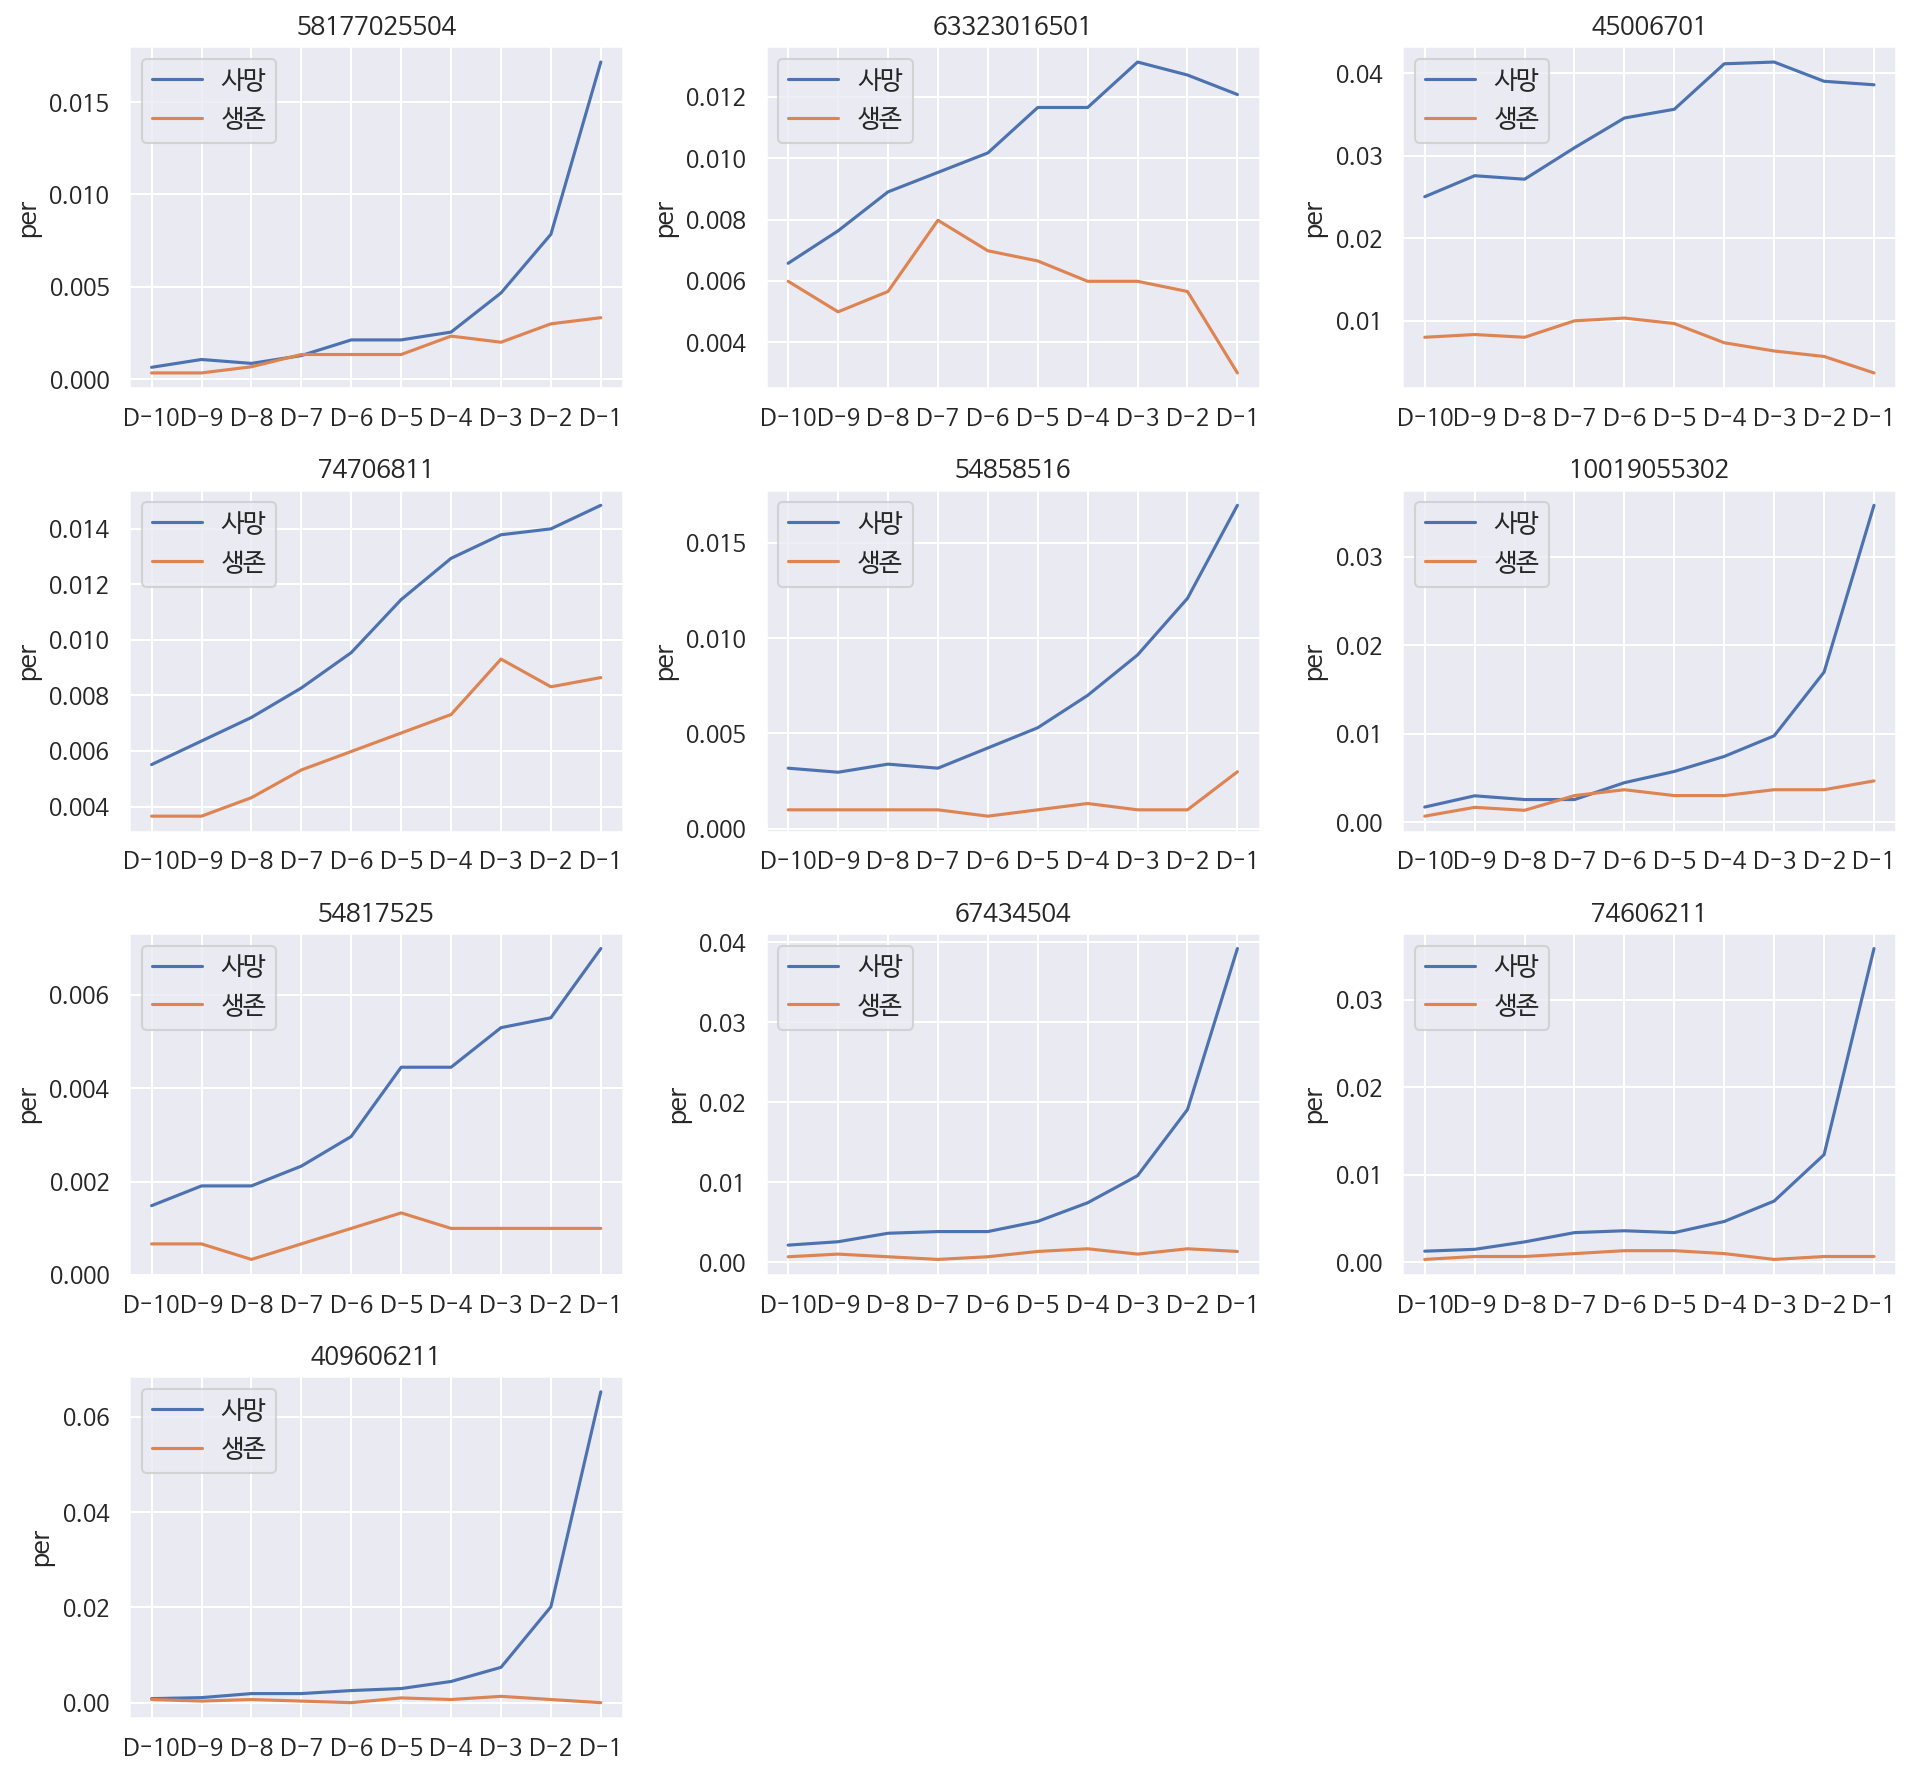

In [36]:
# 하위 10개 - '생존 -> 사망'으로의 변동성이 큰 feature
absum(PRE_list,PRE_list[-10:])

## PRO

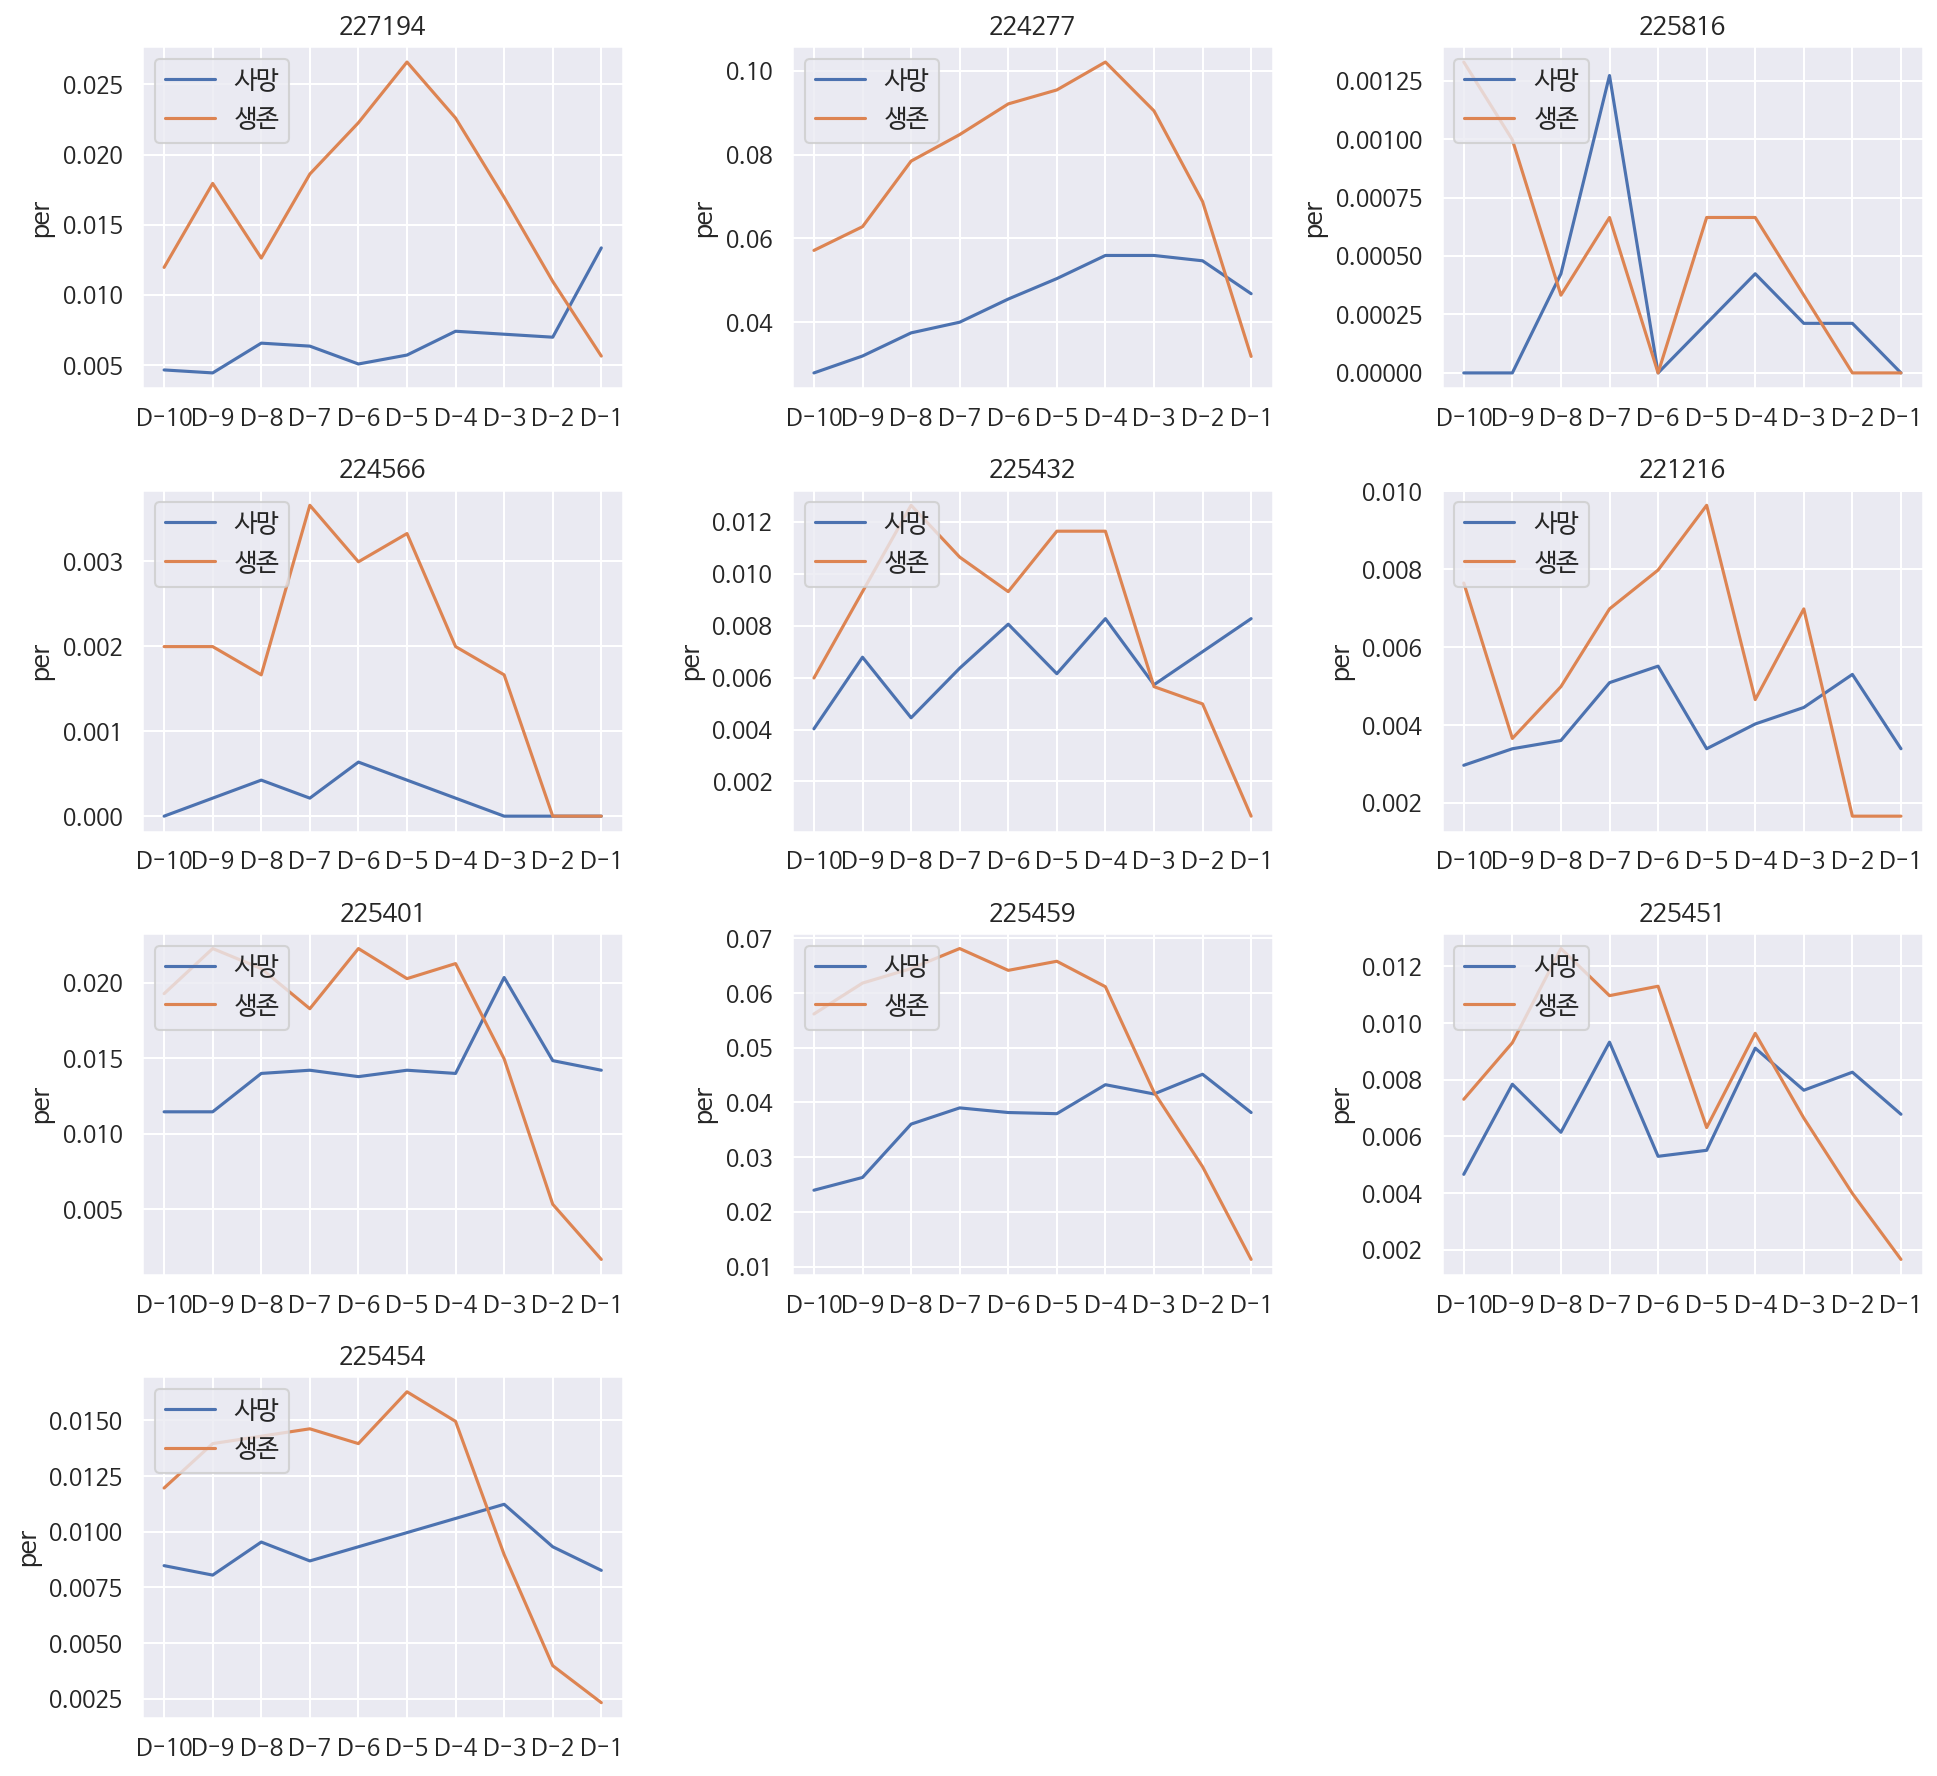

In [37]:
# 상위 10개 - '사망 -> 생존'으로의 변동성이 큰 feature
absum(PRO_list,PRO_list[:10])

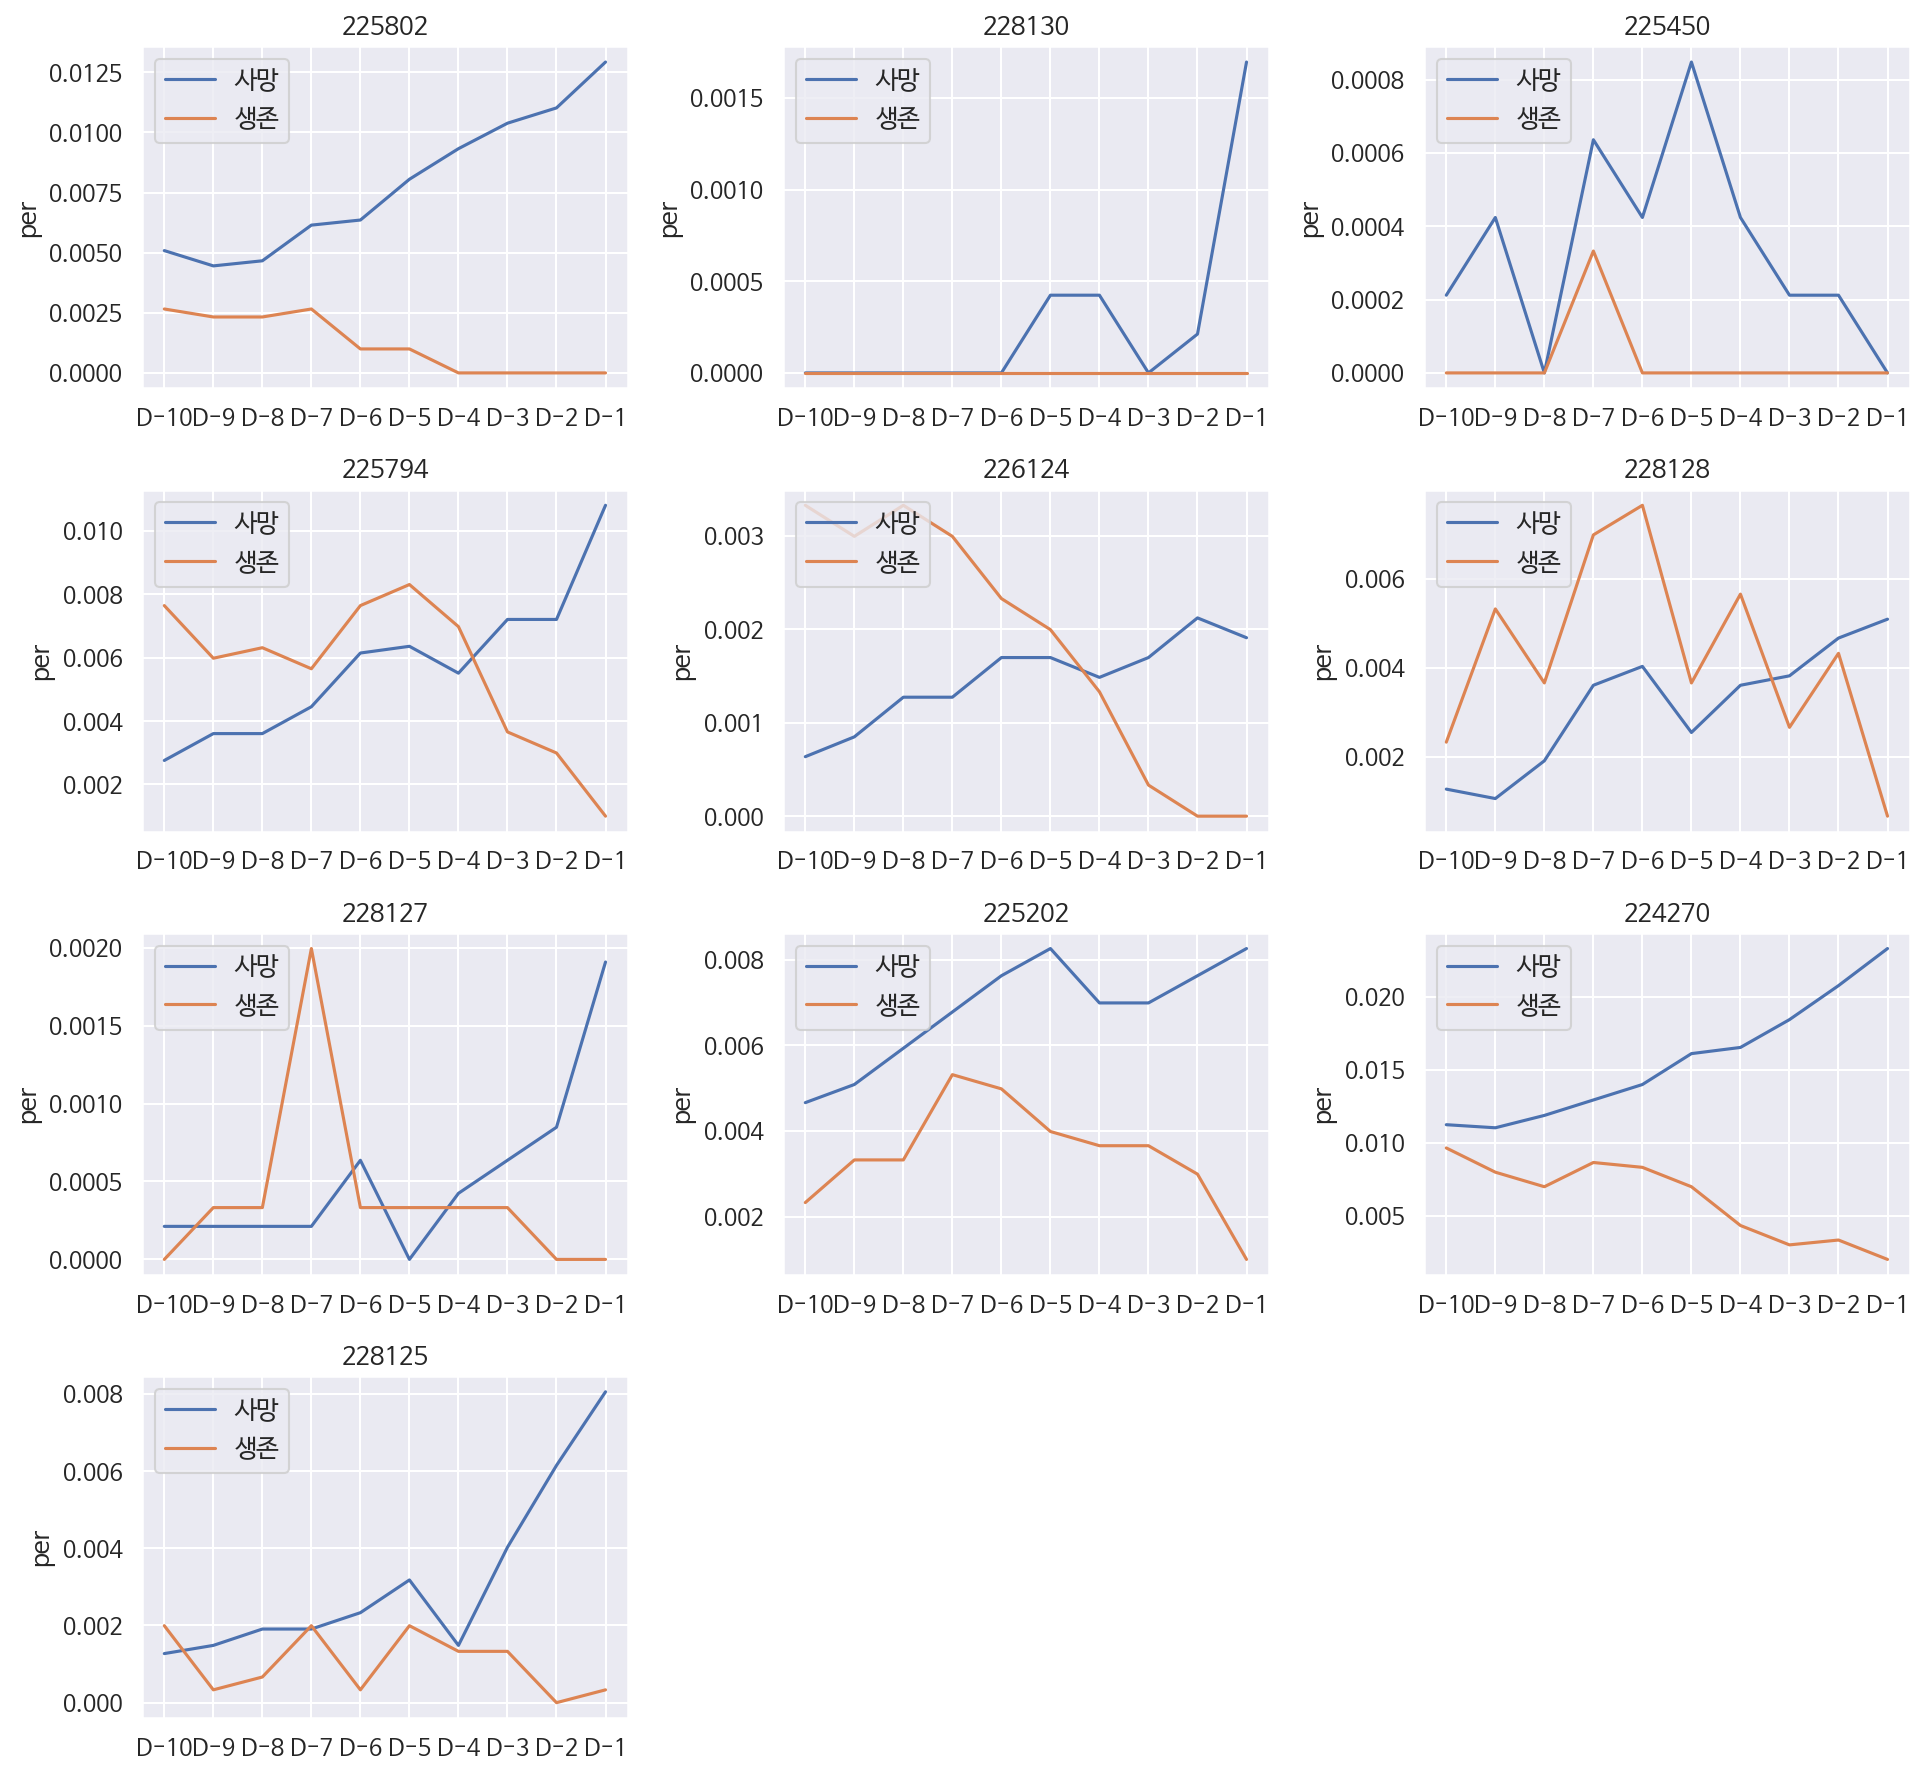

In [38]:
# 하위 10개 - '생존 -> 사망'으로의 변동성이 큰 feature
absum(PRO_list,PRO_list[-10:])

## LAB

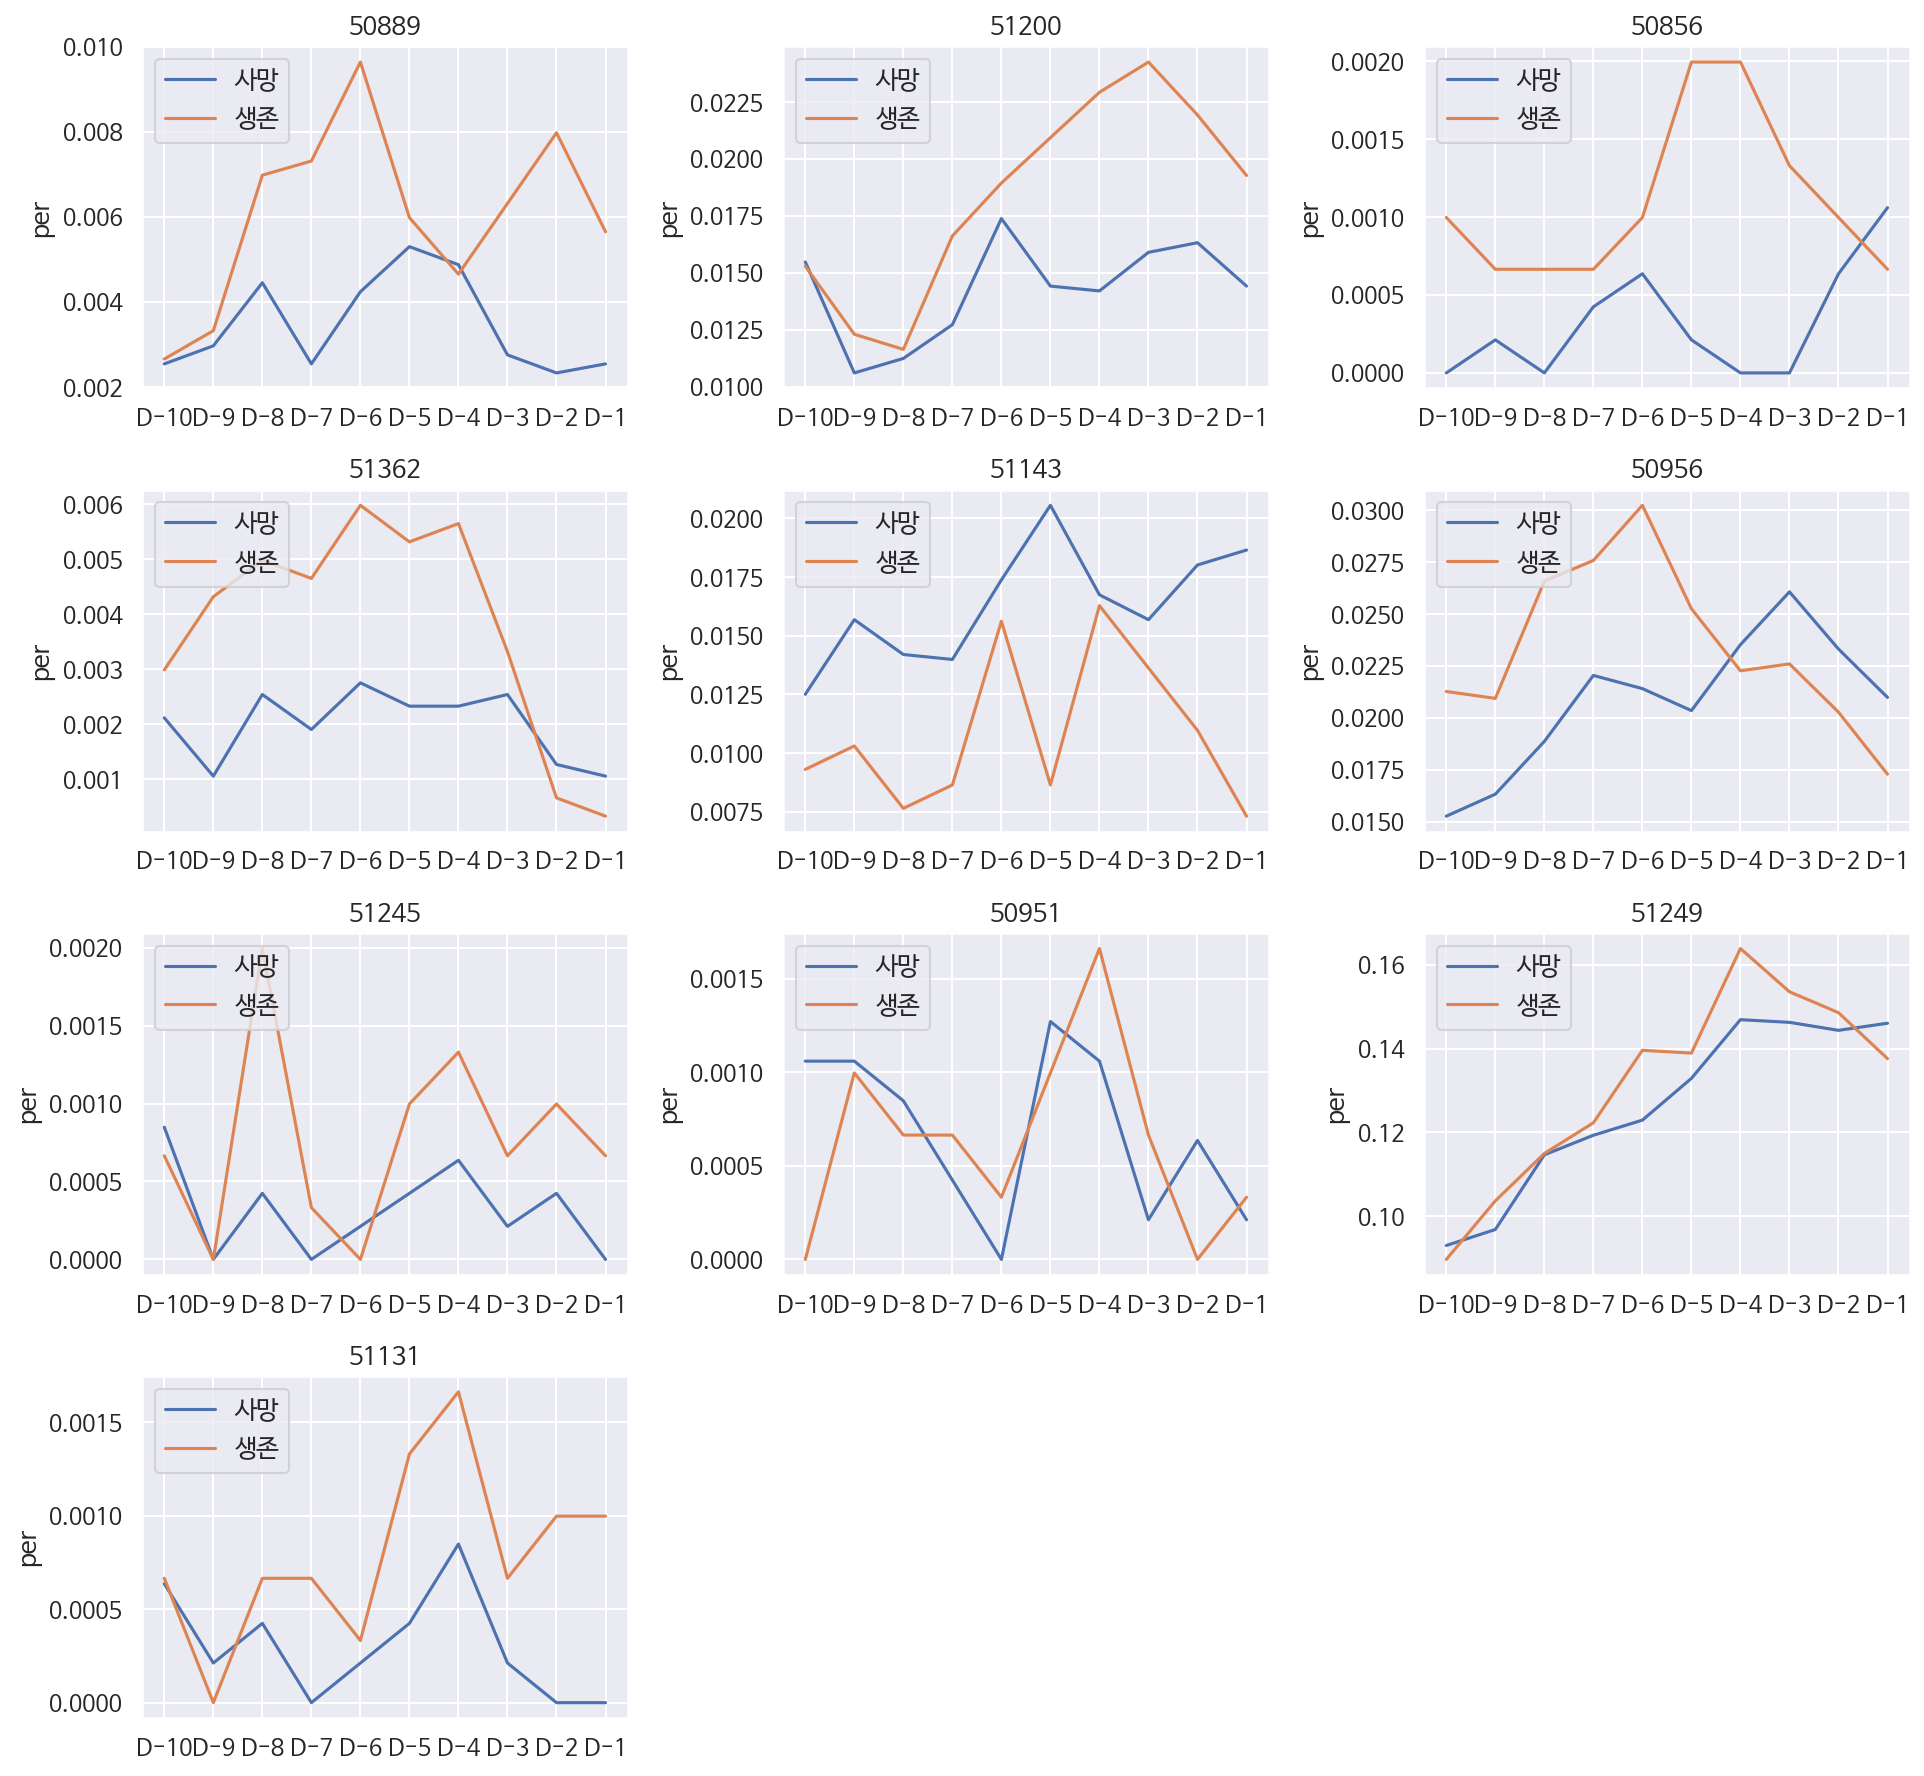

In [39]:
# 상위 10개 - '사망 -> 생존'으로의 변동성이 큰 feature
absum(LAB_list,LAB_list[:10])

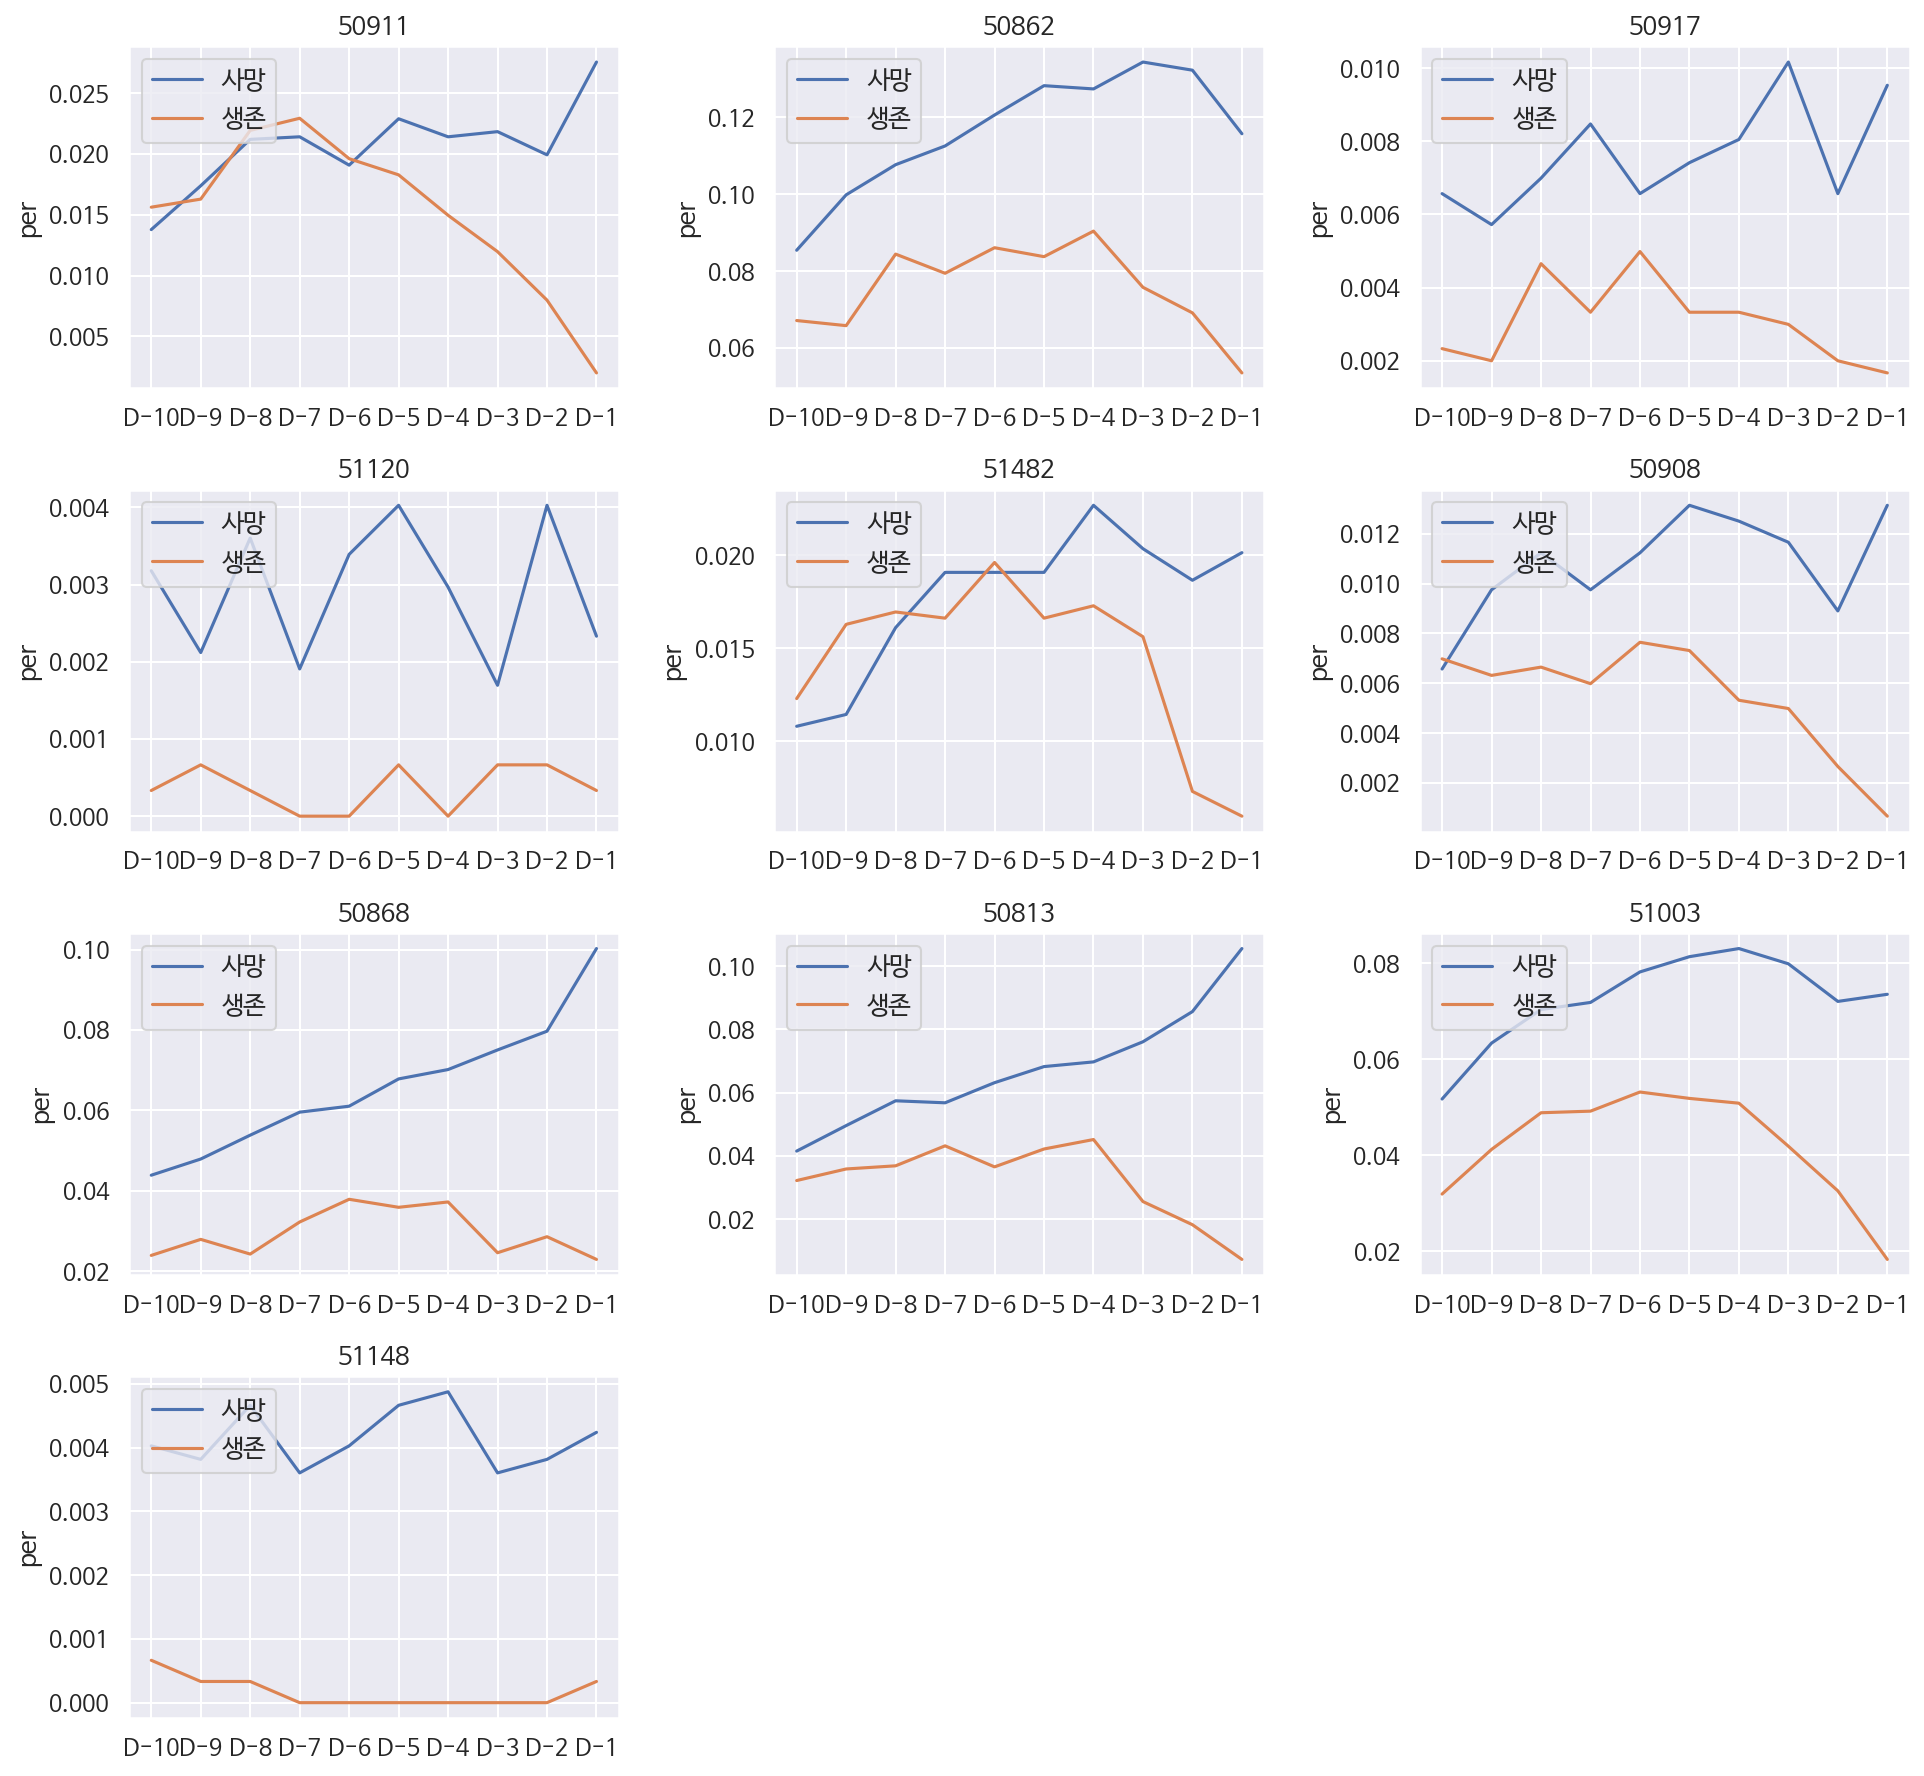

In [40]:
# 하위 10개 - '생존 -> 사망'으로의 변동성이 큰 feature
absum(LAB_list,LAB_list[-10:])

# 검증..
- PRE,PRO,LAB별로 변동성이 큰 itemid는 각각 순위가 어디에 위치할까?
- diff2값 간의 차이가 클까?

In [11]:
method2 = pd.read_csv('method2_df.csv')
method2 = method2.sort_values(ascending=False, by='diff2')

method2[method2['feature'].isin(LAB_list[:10])]
method2[method2['feature'].isin(PRE_list[:10])]
method2[method2['feature'].isin(PRO_list[:10])]

,feature,mul,diff2
3,50889,-0.008520,0.006538
6,51200,-0.007664,0.005728
14,50856,-0.004955,0.003542
21,51362,-0.004472,0.002714
31,51143,-0.003825,0.002137
40,50956,-0.002808,0.001884
46,51245,-0.002498,0.001691
49,50951,-0.003046,0.001677
55,51249,-0.002523,0.001544
60,51131,-0.002275,0.001470


,feature,mul,diff2
1,4003822,-0.009620,0.007752
2,63323016101,-0.008225,0.006699
4,25021011210,-0.008035,0.006379
5,182138167,-0.008059,0.006127
7,172572810,-0.006786,0.005606
8,63323038810,-0.006388,0.004670
9,904585461,-0.006203,0.004521
10,63323018410,-0.004920,0.003976
11,591040401,-0.005434,0.003963
12,50474059540,-0.005172,0.003955


,feature,mul,diff2
0,227194,-0.011878,0.009464
56,224277,-0.002492,0.001534
83,225816,-0.002139,0.001027
100,224566,-0.001731,0.000845
111,225432,-0.001917,0.000738
147,221216,-0.001638,0.000508
182,225401,-0.000938,0.000344
190,225459,-0.001245,0.000310
229,225451,-0.000560,0.000180
231,225454,-0.001372,0.000178
